<a href="https://colab.research.google.com/github/RatnaWijiLestari/CRISP-DM-Methodology/blob/main/MemprediksiPenjualanSetiapProduct/Memprediksi_Penjualan_Produk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Objective**<br>
* Make a model prediction for units_sold for each product.

**Instruction**<br>
* Data understanding : Analisis data kemudian jelaskan<br>
* Data preparation : jelaskan alasan melakukan suatu perubahan pada data<br>
* Modeling : jelaskan alasan memilih suatu algoritma untuk dijadikan model<br>
* Evaluasi : jelaskan evaluasi dari algoritma yang digunakan<br>
* Insight : jelaskan insight yang didapatkan<br>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load and Describe Data

## Load Data

In [ ]:
sales = pd.read_csv('data/summer-products-with-rating-and-performance_2020-08.csv')
print('Total Row', sales.shape[0], ' ,Total Feature', sales.shape[1],'\n')
sales.head(2)

Total Row 1573  ,Total Feature 43 



,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.0,14,EUR,100,0,3.76,54,26.0,...,568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.0,22,EUR,20000,1,3.45,6135,2269.0,...,17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08


## Data Description

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         1573 non-null   object 
 1   title_orig                    1573 non-null   object 
 2   price                         1573 non-null   float64
 3   retail_price                  1573 non-null   int64  
 4   currency_buyer                1573 non-null   object 
 5   units_sold                    1573 non-null   int64  
 6   uses_ad_boosts                1573 non-null   int64  
 7   rating                        1573 non-null   float64
 8   rating_count                  1573 non-null   int64  
 9   rating_five_count             1528 non-null   float64
 10  rating_four_count             1528 non-null   float64
 11  rating_three_count            1528 non-null   float64
 12  rating_two_count              1528 non-null   float64
 13  rat

## Check Null and Missing Values

In [ ]:
data_missing_value = sales.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(sales))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,merchant_profile_picture,1347,85.63
1,has_urgency_banner,1100,69.93
2,urgency_text,1100,69.93
3,rating_two_count,45,2.86
4,rating_five_count,45,2.86
5,rating_four_count,45,2.86
6,rating_three_count,45,2.86
7,rating_one_count,45,2.86
8,product_color,41,2.61
9,origin_country,17,1.08


In [ ]:
col_missing_value = data_missing_value['feature'].tolist()
sales[col_missing_value].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   merchant_profile_picture   226 non-null    object 
 1   has_urgency_banner         473 non-null    float64
 2   urgency_text               473 non-null    object 
 3   rating_two_count           1528 non-null   float64
 4   rating_five_count          1528 non-null   float64
 5   rating_four_count          1528 non-null   float64
 6   rating_three_count         1528 non-null   float64
 7   rating_one_count           1528 non-null   float64
 8   product_color              1532 non-null   object 
 9   origin_country             1556 non-null   object 
 10  product_variation_size_id  1559 non-null   object 
 11  merchant_name              1569 non-null   object 
 12  merchant_info_subtitle     1572 non-null   object 
dtypes: float64(6), object(7)
memory usage: 159.9+ KB

[Text(0, 0, 'merchant_profile_picture'),
 Text(1, 0, 'has_urgency_banner'),
 Text(2, 0, 'urgency_text'),
 Text(3, 0, 'rating_two_count'),
 Text(4, 0, 'rating_five_count'),
 Text(5, 0, 'rating_four_count'),
 Text(6, 0, 'rating_three_count'),
 Text(7, 0, 'rating_one_count'),
 Text(8, 0, 'product_color'),
 Text(9, 0, 'origin_country'),
 Text(10, 0, 'product_variation_size_id'),
 Text(11, 0, 'merchant_name'),
 Text(12, 0, 'merchant_info_subtitle')]

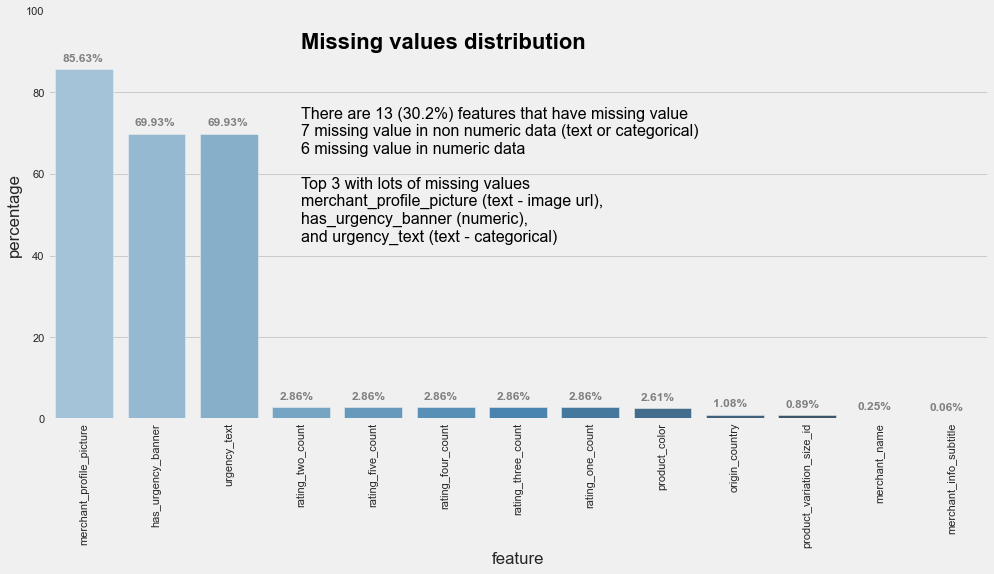

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x = 'feature',y='percentage',data=data_missing_value,ax=ax,
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

x = np.arange(len(data_missing_value['feature']))
y = data_missing_value['percentage']

for i, v in enumerate(y):
    ax.text(x[i]-0.3, v+2, str(v)+'%', fontsize = 12, color='gray', fontweight='bold')

title = '''
Missing values distribution
'''
ax.text(3,85,title,horizontalalignment='left',color='black',fontsize=22,fontweight='bold')


text = '''
There are 13 (30.2%) features that have missing value
7 missing value in non numeric data (text or categorical)
6 missing value in numeric data

Top 3 with lots of missing values
merchant_profile_picture (text - image url),
has_urgency_banner (numeric),
and urgency_text (text - categorical)

'''
ax.text(3,35,text,horizontalalignment='left',color='black',fontsize=16,fontweight='normal')

ax.set_ylim(0,100)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## Numerical Data

In [ ]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(sales.select_dtypes(include=numerics).columns)
print(sales.select_dtypes(include=numerics).shape)
data_num = sales.select_dtypes(include=numerics)
data_num.head(3)

Index(['price', 'retail_price', 'units_sold', 'uses_ad_boosts', 'rating',
       'rating_count', 'rating_five_count', 'rating_four_count',
       'rating_three_count', 'rating_two_count', 'rating_one_count',
       'badges_count', 'badge_local_product', 'badge_product_quality',
       'badge_fast_shipping', 'product_variation_inventory',
       'shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'has_urgency_banner', 'merchant_rating_count',
       'merchant_rating', 'merchant_has_profile_picture'],
      dtype='object')

(1573, 24)


,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture
0,16.0,14,100,0,3.76,54,26.0,8.0,10.0,1.0,...,0,50,4,0,34,50,1.0,568,4.128521,0
1,8.0,22,20000,1,3.45,6135,2269.0,1027.0,1118.0,644.0,...,0,50,2,0,41,50,1.0,17752,3.899673,0
2,8.0,43,100,0,3.57,14,5.0,4.0,2.0,0.0,...,0,1,3,0,36,50,1.0,295,3.989831,0


## Non Numerical Data

In [ ]:
display(sales.select_dtypes(include=['object']).columns)
print(sales.select_dtypes(include=object).shape)
data_cat = sales.select_dtypes(include=['object'])
data_cat.head(3)

Index(['title', 'title_orig', 'currency_buyer', 'tags', 'product_color',
       'product_variation_size_id', 'shipping_option_name', 'urgency_text',
       'origin_country', 'merchant_title', 'merchant_name',
       'merchant_info_subtitle', 'merchant_id', 'merchant_profile_picture',
       'product_url', 'product_picture', 'product_id', 'theme', 'crawl_month'],
      dtype='object')

(1573, 19)


,title,title_orig,currency_buyer,tags,product_color,product_variation_size_id,shipping_option_name,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_id,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,EUR,"Summer,Fashion,womenunderwearsuit,printedpajam...",white,M,Livraison standard,Quantité limitée !,CN,zgrdejia,zgrdejia,(568 notes),595097d6a26f6e070cb878d1,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,EUR,"Mini,womens dresses,Summer,Patchwork,fashion d...",green,XS,Livraison standard,Quantité limitée !,CN,SaraHouse,sarahouse,"83 % avis positifs (17,752 notes)",56458aa03a698c35c9050988,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,EUR,"Summer,cardigan,women beachwear,chiffon,Sexy w...",leopardprint,XS,Livraison standard,Quantité limitée !,CN,hxt520,hxt520,86 % avis positifs (295 notes),5d464a1ffdf7bc44ee933c65,NaN,https://www.wish.com/c/5ea10e2c617580260d55310a,https://contestimg.wish.com/api/webimage/5ea10...,5ea10e2c617580260d55310a,summer,2020-08


**Dari total 43 fitur terdiri dari 24 data numerik dan 19 data non-numrik**

# Data Preparation

In [ ]:
sales = pd.read_csv('data/summer-products-with-rating-and-performance_2020-08.csv')
print('Total Row', sales.shape[0], ' ,Total Feature', sales.shape[1],'\n')

Total Row 1573  ,Total Feature 43 



##  Handle Missing Values - Numerical

Terdapata 6 missing value pada data numerik<br>
has_urgency_banner - 1100 (69.93%)<br>
rating_two_count - 45 (69.93%)<br>
rating_five_count - 45 (2.86%)<br>
rating_four_count - 45 (2.86%)<br>
rating_three_count - 45 (2.86%)<br>
rating_one_count - 45 (2.86%)

**has_urgency_banner**

In [ ]:
sales['has_urgency_banner'].value_counts()

1.0    473
Name: has_urgency_banner, dtype: int64

In [ ]:
sales[['urgency_text','has_urgency_banner']].head()

,urgency_text,has_urgency_banner
0,Quantité limitée !,1.0
1,Quantité limitée !,1.0
2,Quantité limitée !,1.0
3,NaN,NaN
4,Quantité limitée !,1.0


**karena has urgency banner sudah dideskripskan oleh urgency text, sehingga isi missing value dengan 0 ketika urgency_text bernilai nan**

In [ ]:
sales['has_urgency_banner'].replace(np.nan, 0, inplace=True)

**isi missing value pada rating dengan 0, karena kita tahu bahwa rating bersifat optional bagi user**

In [ ]:
# rating features
sales['rating_five_count'].replace(np.nan, 0, inplace=True)
sales['rating_four_count'].replace(np.nan, 0, inplace=True)
sales['rating_three_count'].replace(np.nan, 0, inplace=True)
sales['rating_two_count'].replace(np.nan, 0, inplace=True)
sales['rating_one_count'].replace(np.nan, 0, inplace=True)

## Transform categorical variables

### Check Cardinality

In [ ]:
col_cat = list(data_cat)
for i in col_cat:
    print(i, ' ---UNIQUE VALUE--  ',len(sales[i].unique()))

title  ---UNIQUE VALUE--   1201
title_orig  ---UNIQUE VALUE--   1201
currency_buyer  ---UNIQUE VALUE--   1
tags  ---UNIQUE VALUE--   1230
product_color  ---UNIQUE VALUE--   102
product_variation_size_id  ---UNIQUE VALUE--   107
shipping_option_name  ---UNIQUE VALUE--   15
urgency_text  ---UNIQUE VALUE--   3
origin_country  ---UNIQUE VALUE--   7
merchant_title  ---UNIQUE VALUE--   958
merchant_name  ---UNIQUE VALUE--   958
merchant_info_subtitle  ---UNIQUE VALUE--   1059
merchant_id  ---UNIQUE VALUE--   958
merchant_profile_picture  ---UNIQUE VALUE--   126
product_url  ---UNIQUE VALUE--   1341
product_picture  ---UNIQUE VALUE--   1341
product_id  ---UNIQUE VALUE--   1341
theme  ---UNIQUE VALUE--   1
crawl_month  ---UNIQUE VALUE--   1


### Tags

In [ ]:
sales[['tags']]

,tags
0,"Summer,Fashion,womenunderwearsuit,printedpajam..."
1,"Mini,womens dresses,Summer,Patchwork,fashion d..."
2,"Summer,cardigan,women beachwear,chiffon,Sexy w..."
3,"Summer,Shorts,Cotton,Cotton T Shirt,Sleeve,pri..."
4,"Summer,Plus Size,Lace,Casual pants,Bottom,pant..."
...,...
1568,"bohemia,Plus Size,dandelionfloralprinted,short..."
1569,"Summer,Panties,Elastic,Lace,Casual pants,casua..."
1570,"runningshort,Beach Shorts,beachpant,menbeachsh..."
1571,"Summer,fashion women,Fashion,Lace,Dresses,Dres..."


In [ ]:
sales['tags'].value_counts().head(2)

Summer,Fashion,Necks,Skirts,Dress,Loose,Women's Fashion,Round neck,beach dress,sleeveless,Beach,Casual,Women                                             17
Summer,Sling,Dresses,Dress,V-neck,Casual,Pocket,Women's Fashion,Sleeveless dress,women dress,Floral,sleeveless,Women,loose dress,Pleated,casual dress     9
Name: tags, dtype: int64

**konversi fitur tag menjadi jumlah tag yang dimiliki produk**

In [ ]:
sales['tags'] = sales.tags.str.count(',')

In [ ]:
sales['tags'].values[0]

"Summer,Fashion,womenunderwearsuit,printedpajamasset,womencasualshort,Women's Fashion,flamingo,loungewearset,Casual,Shirt,casualsleepwear,Shorts,flamingotshirt,Elastic,Vintage,Tops,tshirtandshortsset,Women,Sleepwear,Print,womenpajamasset,womennightwear,Pajamas,womensleepwearset"

In [ ]:
sales['tags'].head()

0    23
1    14
2    18
3    17
4    12
Name: tags, dtype: int64

### Product Color

In [ ]:
# sales['product_color'].value_counts()

In [ ]:
sales['product_color'].replace('armygreen', 'green', inplace=True)
sales['product_color'].replace('winered', 'red', inplace=True)
sales['product_color'].replace('navyblue', 'blue', inplace=True)
sales['product_color'].replace('lightblue', 'blue', inplace=True)
sales['product_color'].replace('khaki', 'green', inplace=True)
sales['product_color'].replace('gray', 'grey', inplace=True)
sales['product_color'].replace('rosered', 'red', inplace=True)
sales['product_color'].replace('skyblue', 'blue', inplace=True)
sales['product_color'].replace('coffee', 'brown', inplace=True)
sales['product_color'].replace('darkblue', 'blue', inplace=True)
sales['product_color'].replace('rose', 'red', inplace=True)
sales['product_color'].replace('fluorescentgreen', 'green', inplace=True)
sales['product_color'].replace('navy', 'blue', inplace=True)
sales['product_color'].replace('lightpink', 'pink', inplace=True)
sales['product_color'].replace('orange-red', 'red', inplace=True)
sales['product_color'].replace('Black', 'black', inplace=True)
sales['product_color'].replace('lightgreen', 'green', inplace=True)
sales['product_color'].replace('White', 'white', inplace=True)
sales['product_color'].replace('wine', 'red', inplace=True)
sales['product_color'].replace('Pink', 'pink', inplace=True)
sales['product_color'].replace('Army green', 'green', inplace=True)
sales['product_color'].replace('coralred', 'red', inplace=True)
sales['product_color'].replace('lightred', 'red', inplace=True)
sales['product_color'].replace('apricot', 'orange', inplace=True)
sales['product_color'].replace('navy blue', 'blue', inplace=True)
sales['product_color'].replace('burgundy', 'red', inplace=True)
sales['product_color'].replace('silver', 'grey', inplace=True)
sales['product_color'].replace('camel', 'brown', inplace=True)
sales['product_color'].replace('lakeblue', 'blue', inplace=True)
sales['product_color'].replace('lightyellow', 'yellow', inplace=True)
sales['product_color'].replace('watermelonred', 'red', inplace=True)
sales['product_color'].replace('coolblack', 'black', inplace=True)
sales['product_color'].replace('applegreen', 'green', inplace=True)
sales['product_color'].replace('mintgreen', 'green', inplace=True)
sales['product_color'].replace('dustypink', 'pink', inplace=True)
sales['product_color'].replace('ivory', 'white', inplace=True)
sales['product_color'].replace('lightkhaki', 'green', inplace=True)
sales['product_color'].replace('lightgray', 'grey', inplace=True)
sales['product_color'].replace('darkgreen', 'green', inplace=True)
sales['product_color'].replace('RED', 'red', inplace=True)
sales['product_color'].replace('tan', 'brown', inplace=True)
sales['product_color'].replace('jasper', 'red', inplace=True)
sales['product_color'].replace('nude', 'white', inplace=True)
sales['product_color'].replace('army', 'brown', inplace=True)
sales['product_color'].replace('light green', 'green', inplace=True)
sales['product_color'].replace('offwhite', 'white', inplace=True)
sales['product_color'].replace('Blue', 'blue', inplace=True)
sales['product_color'].replace('denimblue', 'blue', inplace=True)
sales['product_color'].replace('Rose red', 'red', inplace=True)
sales['product_color'].replace('lightpurple', 'purple', inplace=True)
sales['product_color'].replace('prussianblue', 'blue', inplace=True)
sales['product_color'].replace('offblack', 'black', inplace=True)
sales['product_color'].replace('violet', 'purple', inplace=True)
sales['product_color'].replace('gold', 'yellow', inplace=True)
sales['product_color'].replace('wine red', 'red', inplace=True)
sales['product_color'].replace('rosegold', 'red', inplace=True)
sales['product_color'].replace('claret', 'red', inplace=True)
sales['product_color'].replace('army green', 'green', inplace=True)
sales['product_color'].replace('lightgrey', 'grey', inplace=True)
sales['product_color'].replace(np.nan, 'others', inplace=True)

In [ ]:
def color(col):
    ls = ['black', 'white', 'blue', 'red', 'green', 'yellow', 'pink', 'grey', 'purple', 'orange', 'brown', 'beige']
    if col not in ls:
        if '&' in col:
            return 'dual'
        else:
            return 'others'
    return col

In [ ]:
sales['product_color'] = sales['product_color'].apply(color)

In [ ]:
sales['product_color'].value_counts()

black     308
white     260
blue      164
red       153
green     150
yellow    108
pink      107
grey       86
others     81
purple     55
dual       40
orange     29
brown      18
beige      14
Name: product_color, dtype: int64

In [ ]:
temp_product_color = sales[['product_color']]

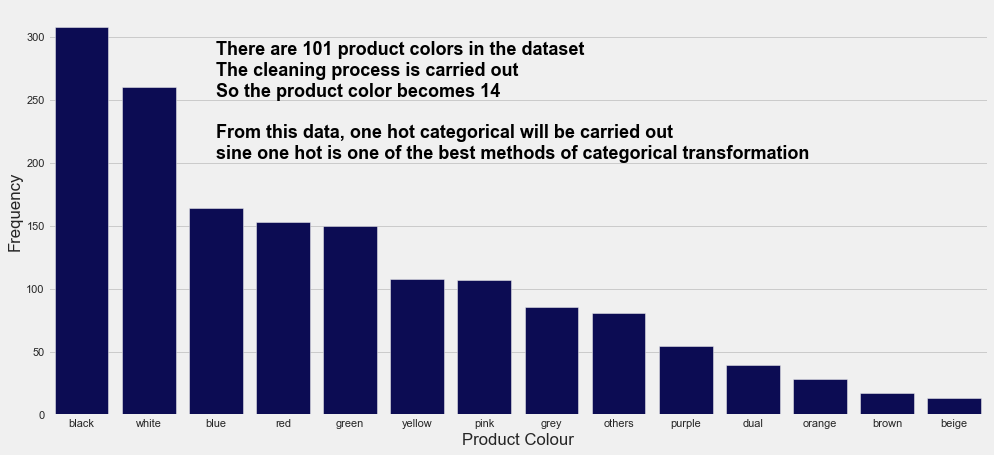

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x = 'product_color', data = sales,
              order = sales['product_color'].value_counts().iloc[:].index,
             color='#00005f')



text = '''
There are 101 product colors in the dataset
The cleaning process is carried out
So the product color becomes 14

From this data, one hot categorical will be carried out
sine one hot is one of the best methods of categorical transformation

'''
ax.text(2,170,text,horizontalalignment='left',color='black',fontsize=18,fontweight='bold')



plt.xlabel('Product Colour')
plt.ylabel('Frequency')
plt.show()

**update product_color value with one hot encoding categorical**

In [ ]:
# product color
dummies_color = pd.get_dummies(sales['product_color'], drop_first=True) # give us the one hot ecoded features
dummies_color.drop(labels = 'others', axis=1, inplace=True) # remove the 'others' feature as n-1 encoded features represents n features

In [ ]:
dummies_color.head()

,black,blue,brown,dual,green,grey,orange,pink,purple,red,white,yellow
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
#merge this data at the end
# sales = pd.concat([sales, dummies_color], axis=1)

In [ ]:
sales = sales.drop('product_color', axis=1)

### Product Variation Size Id

In [ ]:
sales['product_variation_size_id'].value_counts()

S                      641
XS                     356
M                      200
XXS                    100
L                       49
                      ... 
Size--S                  1
4-5 Years                1
5PAIRS                   1
US 6.5 (EU 37)           1
AU plug Low quality      1
Name: product_variation_size_id, Length: 106, dtype: int64

In [ ]:
sales['product_variation_size_id'].replace('S.', 'S', inplace=True)
sales['product_variation_size_id'].replace('Size S', 'S', inplace=True)
sales['product_variation_size_id'].replace('XS.', 'XS', inplace=True)
sales['product_variation_size_id'].replace('s', 'S', inplace=True)
sales['product_variation_size_id'].replace('M.', 'M', inplace=True)
sales['product_variation_size_id'].replace('2XL', 'XXL', inplace=True)
sales['product_variation_size_id'].replace('Size XS', 'XS', inplace=True)
sales['product_variation_size_id'].replace('Size-XS', 'XS', inplace=True)
sales['product_variation_size_id'].replace('4XL', 'XXXXL', inplace=True)
sales['product_variation_size_id'].replace('SIZE XS', 'XS', inplace=True)
sales['product_variation_size_id'].replace('SizeL', 'L', inplace=True)
sales['product_variation_size_id'].replace('Size-S', 'S', inplace=True)
sales['product_variation_size_id'].replace('5XL', 'XXXXXL', inplace=True)
sales['product_variation_size_id'].replace('3XL', 'XXXL', inplace=True)
sales['product_variation_size_id'].replace('S(bust 88cm)', 'S', inplace=True)
sales['product_variation_size_id'].replace('Size4XL', 'XXXXL', inplace=True)
sales['product_variation_size_id'].replace('Size -XXS', 'XXS', inplace=True)
sales['product_variation_size_id'].replace('SIZE-XXS', 'XXS', inplace=True)
sales['product_variation_size_id'].replace('Size M', 'M', inplace=True)
sales['product_variation_size_id'].replace('size S', 'S', inplace=True)
sales['product_variation_size_id'].replace('S Pink', 'S', inplace=True)
sales['product_variation_size_id'].replace('Size S.', 'S', inplace=True)
sales['product_variation_size_id'].replace('Suit-S', 'S', inplace=True)

In [ ]:
def size_name(size):
    ls = ["XXXS", "XXS", "XS", "S", "M", "L", "XL", "XXL", "XXXL", "XXXXL", "XXXXXL"]
    if size in ls:
        return size
    return "Others"

In [ ]:
sales['product_variation_size_id'].replace(np.nan, 'Others', inplace=True)
sales['product_variation_size_id'] = sales['product_variation_size_id'].apply(size_name)

In [ ]:
sales['product_variation_size_id'].value_counts()

S         682
XS        369
M         206
XXS       104
Others    102
L          52
XXL        19
XL         17
XXXXL       9
XXXS        6
XXXXXL      4
XXXL        3
Name: product_variation_size_id, dtype: int64

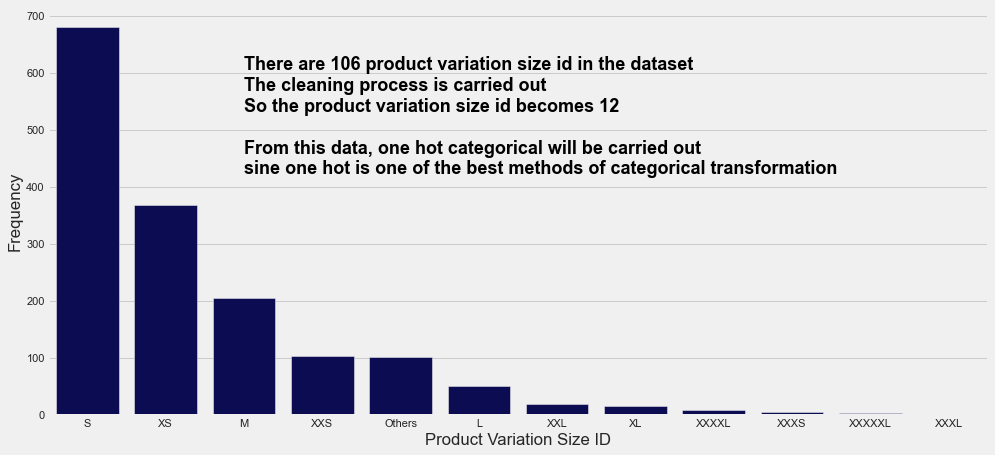

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x = 'product_variation_size_id', data = sales,
              order = sales['product_variation_size_id'].value_counts().iloc[:].index,
             color='#00005f')



text = '''
There are 106 product variation size id in the dataset
The cleaning process is carried out
So the product variation size id becomes 12

From this data, one hot categorical will be carried out
sine one hot is one of the best methods of categorical transformation

'''
ax.text(2,350,text,horizontalalignment='left',color='black',fontsize=18,fontweight='bold')

plt.xlabel('Product Variation Size ID')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# product variation size id
dummies_variation = pd.get_dummies(sales['product_variation_size_id'])
dummies_variation.drop(labels = ['Others'], axis = 1, inplace=True)

In [ ]:
#merge this data at the end
# sales = pd.concat([sales, dummies_variation], axis=1)

In [ ]:
sales = sales.drop('product_variation_size_id', axis=1)

### Origin country

In [ ]:
sales['origin_country'].value_counts()

CN    1516
US      31
VE       5
SG       2
GB       1
AT       1
Name: origin_country, dtype: int64

In [ ]:
def origin_name(country):
    ls = ["VE", "SG", "GB", "AT"]
    if country in ls:
        return "Others"
    return country

In [ ]:
sales['origin_country'].replace(np.nan, "Others", inplace=True)
sales['origin_country'] = sales['origin_country'].apply(origin_name)

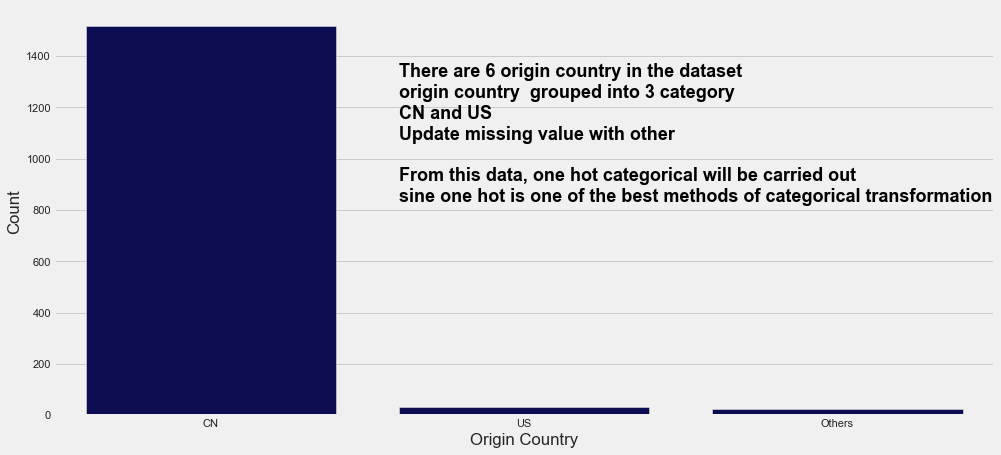

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x = 'origin_country', data = sales,
              order = sales['origin_country'].value_counts().iloc[:].index,
             color='#00005f')

text = '''
There are 6 origin country in the dataset
origin country  grouped into 3 category
CN and US
Update missing value with other

From this data, one hot categorical will be carried out
sine one hot is one of the best methods of categorical transformation

'''
ax.text(0.6,670,text,horizontalalignment='left',color='black',fontsize=18,fontweight='bold')

plt.xlabel('Origin Country')
plt.ylabel('Count')
plt.show()

**update fitur origin_country dengan one hot encoding**

In [ ]:
dummies_origin = pd.get_dummies(sales['origin_country'])
dummies_origin.drop(labels=['Others'], axis = 1, inplace=True)

In [ ]:
# sales = pd.concat([sales, dummies_origin], axis=1)

In [ ]:
sales = sales.drop('origin_country', axis=1)

### Shipping Option Name

In [ ]:
sales['shipping_option_name'].value_counts()

Livraison standard         1508
Standard Shipping            21
Envio Padrão                  9
Expediere Standard            6
Envío normal                  5
الشحن القياسي                 4
Standardowa wysyłka           3
Стандартная доставка          3
Standardversand               3
Livraison Express             3
Standart Gönderi              2
การส่งสินค้ามาตรฐาน           2
Spedizione standard           2
Ekspresowa wysyłka            1
ការដឹកជញ្ជូនតាមស្តង់ដារ       1
Name: shipping_option_name, dtype: int64

**update nilai Livraison standard dengan 1 jika bukan Livraison standard maka update dengan nilai 0**

In [ ]:
sales['shipping_option_name'] = np.where(sales['shipping_option_name']=='Livraison standard',1,0)

## Remove features

**Remove fitur yang hanya memiliki 1 nilai**

In [ ]:
one_value = sales.nunique()
one_value[one_value==1]

currency_buyer    1
theme             1
crawl_month       1
dtype: int64

In [ ]:
sales = sales.drop(['currency_buyer','theme','crawl_month'], axis=1)

**remove fitur title dan title_orig karena fitur tidak akan digunakan**

In [ ]:
sales = sales.drop(['title','title_orig'], axis=1)

**remove urgency_text, karena informasinya sudah tercover oleh fitur has_urgency_banner**

In [ ]:
sales = sales.drop(['urgency_text'], axis=1)

**remove fitur product_url dan product_id karena fitur tidak akan digunakan**

In [ ]:
sales = sales.drop(['product_id','product_picture','product_url'], axis=1)

**There are 5 merchant-related profile features in categorical type. In my opinon that's unused feature**

**Remove fitur merchant karena secara knowledge bisnis tidak akan digunakan ke tahap modeling**

In [ ]:
sales = sales.drop(['merchant_title','merchant_name',
                    'merchant_info_subtitle','merchant_id',
                    'merchant_profile_picture'], axis=1)

## Matrix Correlation

In [ ]:
# concatenating all the one hot encoded features for the three categorical variables above

onehot_feature = pd.concat([dummies_color, dummies_variation, dummies_origin, sales['units_sold']], axis=1)
onehot_feature.head(1)

,black,blue,brown,dual,green,grey,orange,pink,purple,red,...,XS,XXL,XXS,XXXL,XXXS,XXXXL,XXXXXL,CN,US,units_sold
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,100


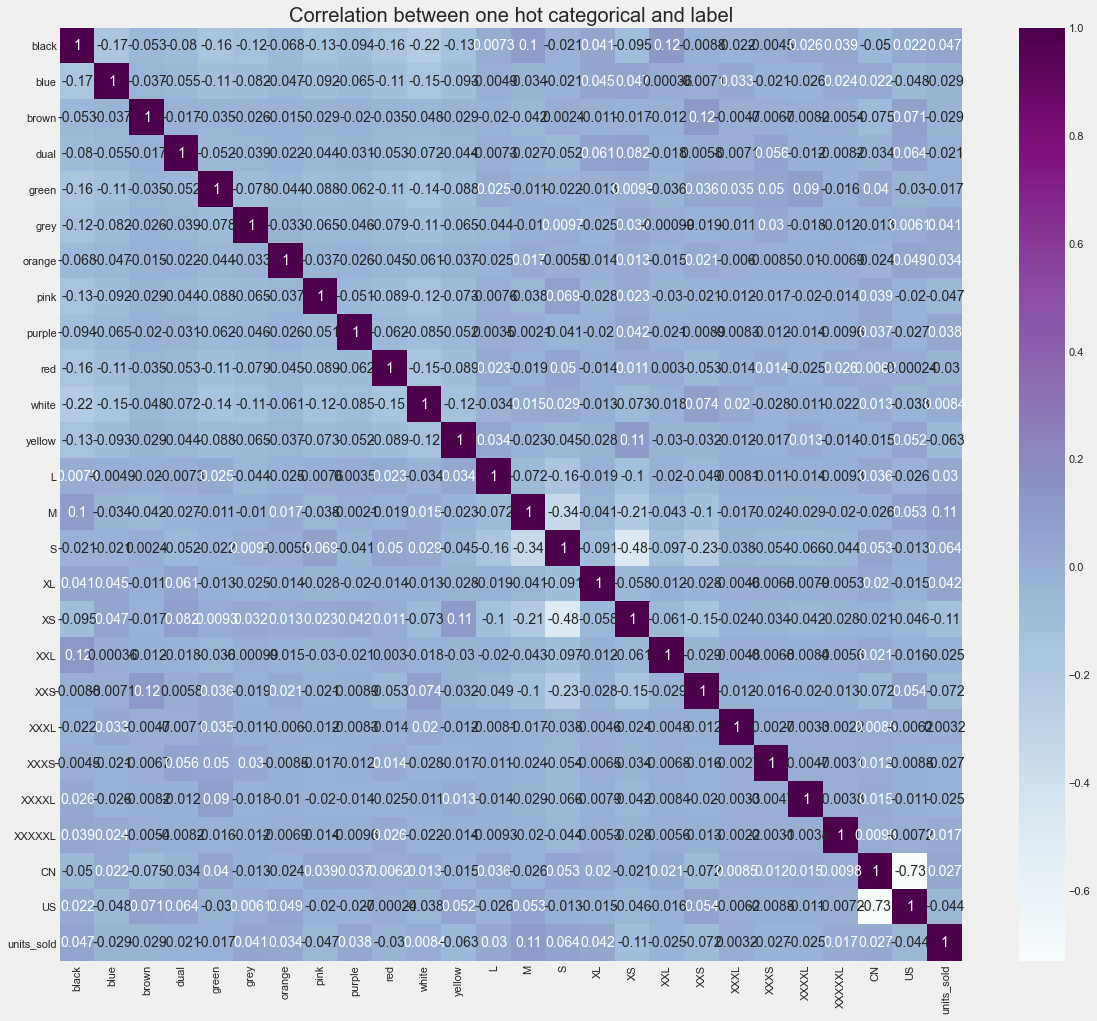

In [ ]:
onehot_feature_corr = onehot_feature.corr()

plt.figure(figsize = (18, 16))
sns.heatmap(onehot_feature_corr, annot=True, cmap='BuPu')
plt.title('Correlation between one hot categorical and label')
plt.show()

In [ ]:
onehot_feature_corr['units_sold'].sort_values(ascending=False)

units_sold    1.000000
M             0.107101
S             0.063655
black         0.046767
XL            0.042029
grey          0.041432
purple        0.037679
orange        0.034395
L             0.029851
CN            0.026664
XXXXXL        0.017198
white         0.008433
XXXL          0.003245
green        -0.016570
dual         -0.021030
XXL          -0.024689
XXXXL        -0.024773
XXXS         -0.027051
blue         -0.028643
brown        -0.028790
red          -0.030292
US           -0.044473
pink         -0.046868
yellow       -0.063270
XXS          -0.072489
XS           -0.112293
Name: units_sold, dtype: float64

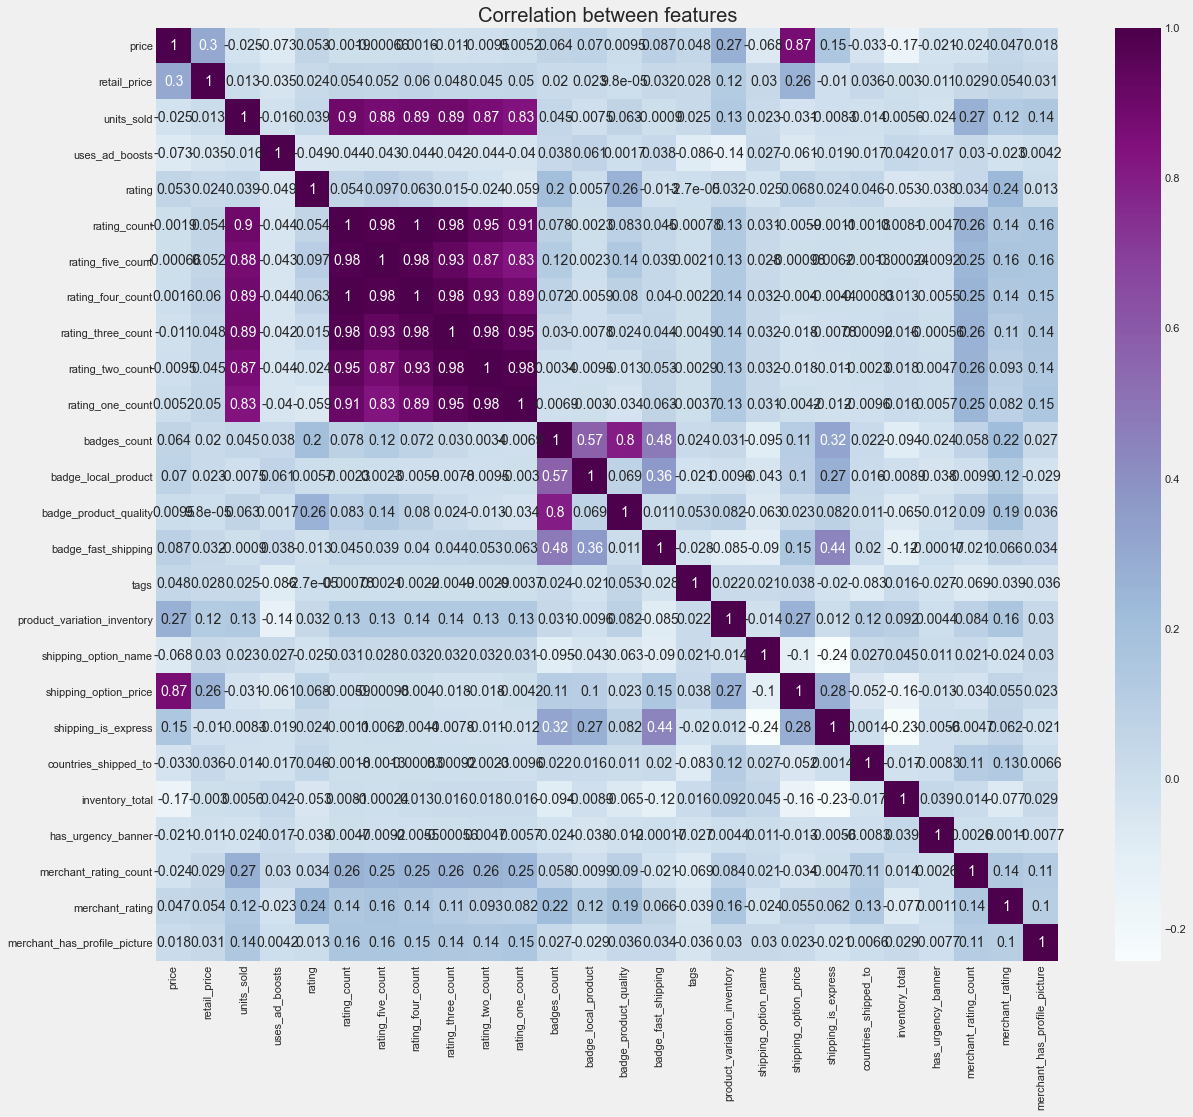

In [ ]:
sales_corr = sales.corr()

plt.figure(figsize = (18, 16))
sns.heatmap(sales_corr, annot=True, cmap='BuPu')
plt.title('Correlation between features')
plt.show()

In [ ]:
sales_corr['units_sold'].sort_values(ascending=False)

units_sold                      1.000000
rating_count                    0.899464
rating_three_count              0.894835
rating_four_count               0.891761
rating_five_count               0.876972
rating_two_count                0.867406
rating_one_count                0.833807
merchant_rating_count           0.272897
merchant_has_profile_picture    0.143529
product_variation_inventory     0.133846
merchant_rating                 0.122504
badge_product_quality           0.063187
badges_count                    0.045402
rating                          0.039478
tags                            0.025363
shipping_option_name            0.023045
retail_price                    0.012638
inventory_total                 0.005608
badge_fast_shipping            -0.000898
badge_local_product            -0.007544
shipping_is_express            -0.008308
countries_shipped_to           -0.013553
uses_ad_boosts                 -0.016055
has_urgency_banner             -0.023891
price           

**rating feature have high correlation each other and high correlation with label**

## EDA & Feature Engineering

### Price Feature

**berdasarkan korelasi matrix, price memiliki korelasi yang negatih terhadap unit penjualan**

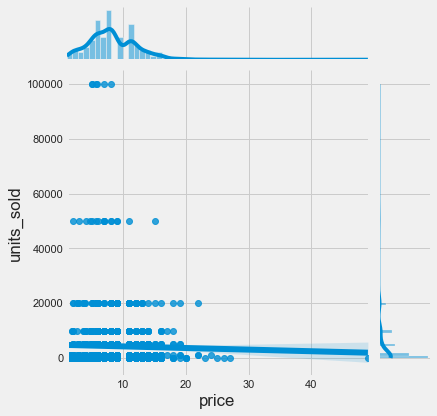

In [ ]:
sns.jointplot(x="price", y="units_sold", data=sales, kind="reg");

19


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])]

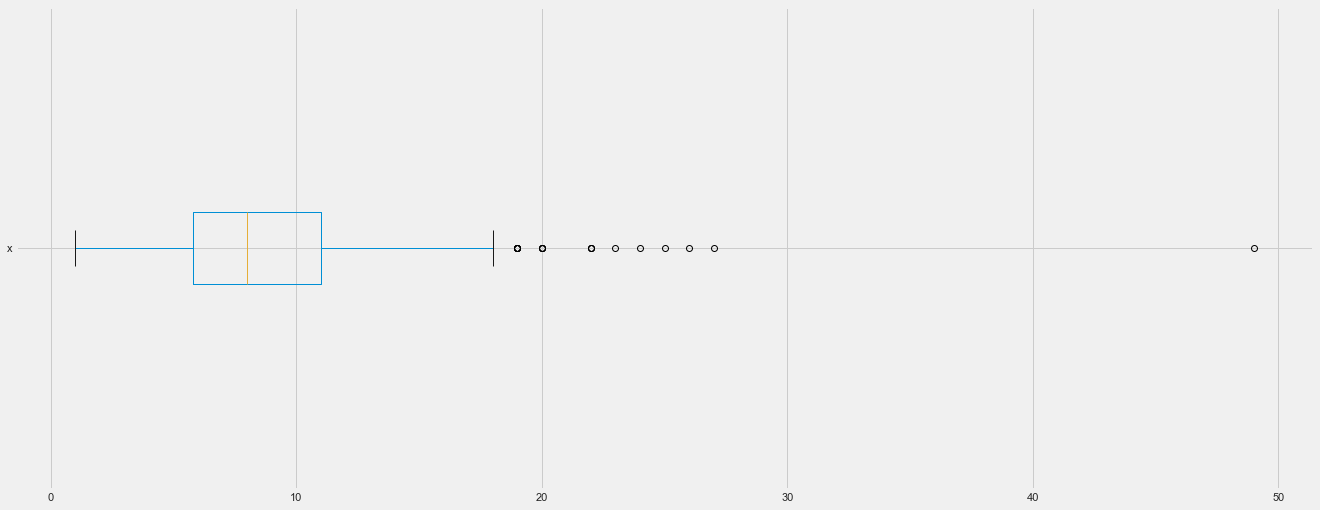

In [ ]:
_, bp = pd.DataFrame.boxplot((sales['price']), return_type='both',vert=False)

outliers = [flier.get_ydata() for flier in bp["fliers"]]
print(len(outliers[0]))
outliers[0].min()
outliers

**Fitur price memiliki korelasi negatif terhadap unit sold. Secara hipotesis, artinya jika ada kenaikan harga maka akan berdampak pada penurunan unit sold. Selain itu terdapat 19 (1.2%) outlier pada price, artinya ada produk yang memiliki harga yang tidak masuk akal (terlalu murah atau terlalu mahal**

### Retail Price

**berdasarkan korelasi matrix, fitur retail price memiliki korelasi positif terhadap unit sold**

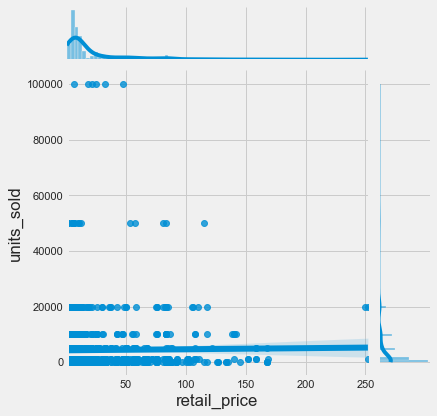

In [ ]:
sns.jointplot(x="retail_price", y="units_sold", data=sales, kind="reg");

208


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.])]

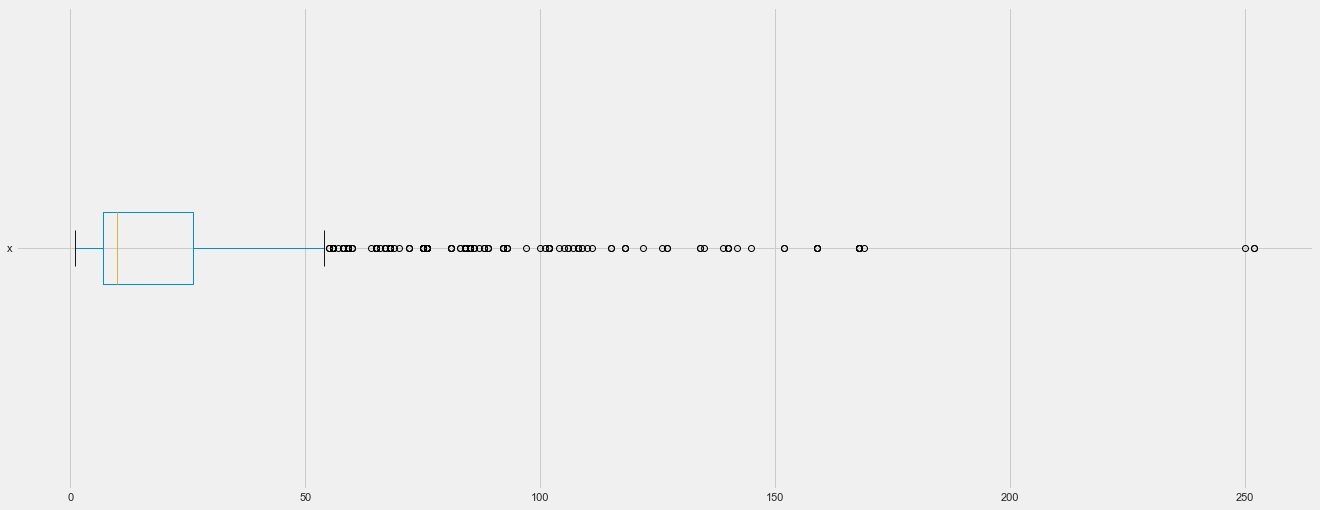

In [ ]:
_, bp = pd.DataFrame.boxplot((sales['retail_price']), return_type='both',vert=False)

outliers = [flier.get_ydata() for flier in bp["fliers"]]
print(len(outliers[0]))
outliers[0].min()
outliers

**retail price memiliki korelasi positif terhadap unit sold. secara hipotesis, artinya kenaikan retail price tidak terlalu pengaruh terhadap penurunan unit sold. Terdapat 208 (13.2%) outlier di retail_price**

### Discount price

**ini merupakan fitur baru dimana perhitungannya dari price - retail price**

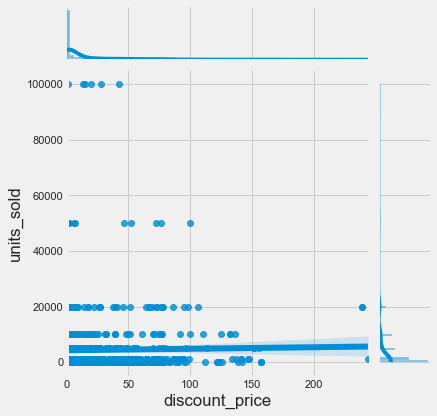

In [ ]:
sales['discount_price'] = abs(sales['price'] - sales['retail_price'])

sns.jointplot(x="discount_price", y="units_sold", data=sales, kind="reg");

In [ ]:
sales_corr = sales.corr()
sales_corr['units_sold']['discount_price']

0.01713439866206904

**diskon memiliki korelasi positif terhadap unit sold dan ini merupakan hal yang wajar. Secara general, lebih banyak diskon akan meningkatkan penjualan**

### Rating

**rating, rating_count, rating_one_count, rating_two_count, rating_three_count, rating_four_count, rating_five_count**

Text(0.5, 0, '')

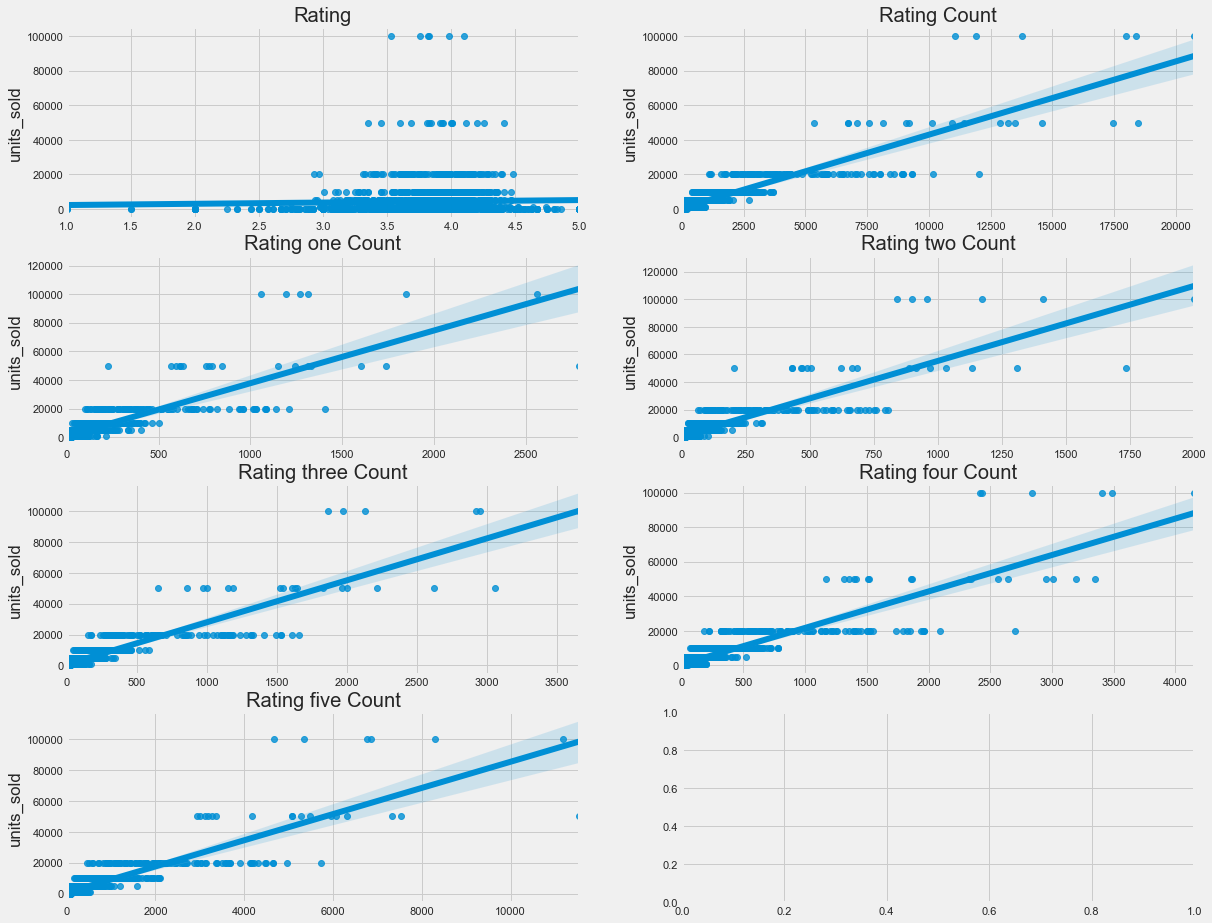

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(18,15))

g = sns.regplot(x="rating", y="units_sold", data=sales, ax=ax[0,0])
ax[0,0].set_title('Rating')
ax[0,0].set_xlabel('')

g = sns.regplot(x="rating_count", y="units_sold", data=sales, ax=ax[0,1])
ax[0,1].set_title('Rating Count')
ax[0,1].set_xlabel('')

g = sns.regplot(x="rating_one_count", y="units_sold", data=sales, ax=ax[1,0])
ax[1,0].set_title('Rating one Count')
ax[1,0].set_xlabel('')

g = sns.regplot(x="rating_two_count", y="units_sold", data=sales, ax=ax[1,1])
ax[1,1].set_title('Rating two Count')
ax[1,1].set_xlabel('')

g = sns.regplot(x="rating_three_count", y="units_sold", data=sales, ax=ax[2,0])
ax[2,0].set_title('Rating three Count')
ax[2,0].set_xlabel('')

g = sns.regplot(x="rating_four_count", y="units_sold", data=sales, ax=ax[2,1])
ax[2,1].set_title('Rating four Count')
ax[2,1].set_xlabel('')

g = sns.regplot(x="rating_five_count", y="units_sold", data=sales, ax=ax[3,0])
ax[3,0].set_title('Rating five Count')
ax[3,0].set_xlabel('')

**Fitur rating memiliki korelasi yang kuat terhadap unit sold, dapat diasumsikan bahwa penjualan produk bergantung pada rating yang dimiliki produk tersebut**

### Badges

**badges_count, badge_local_product, badge_product_quality, badge_fast_shipping**

Text(0.5, 0, '')

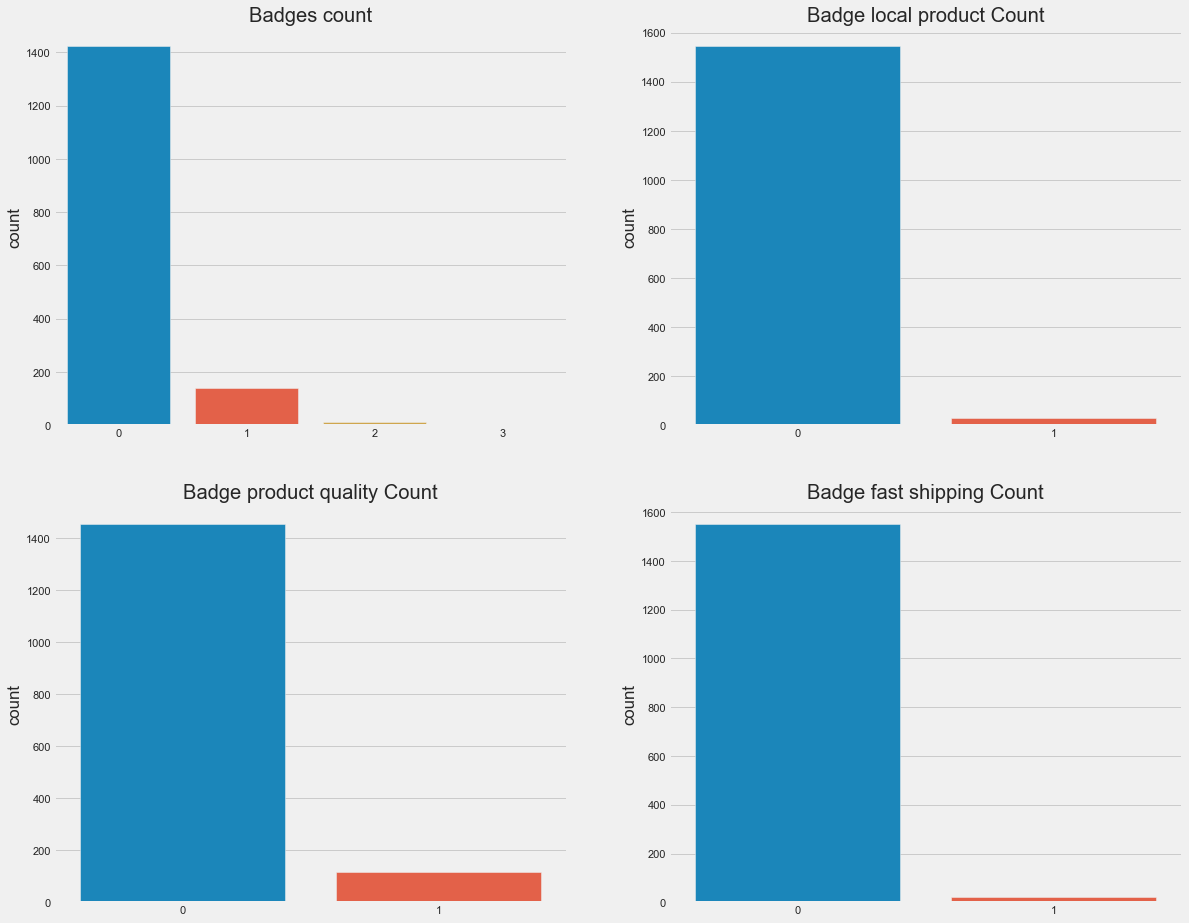

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.countplot(x="badges_count", data=sales, ax=ax[0,0])
ax[0,0].set_title('Badges count')
ax[0,0].set_xlabel('')

g = sns.countplot(x="badge_local_product", data=sales, ax=ax[0,1])
ax[0,1].set_title('Badge local product Count')
ax[0,1].set_xlabel('')

g = sns.countplot(x="badge_product_quality", data=sales, ax=ax[1,0])
ax[1,0].set_title('Badge product quality Count')
ax[1,0].set_xlabel('')

g = sns.countplot(x="badge_fast_shipping", data=sales, ax=ax[1,1])
ax[1,1].set_title('Badge fast shipping Count')
ax[1,1].set_xlabel('')


**Badges data are of type category and the majority of their values are 1. This means the majority of products have a value of 1 on the badge**

Text(0.5, 0, '')

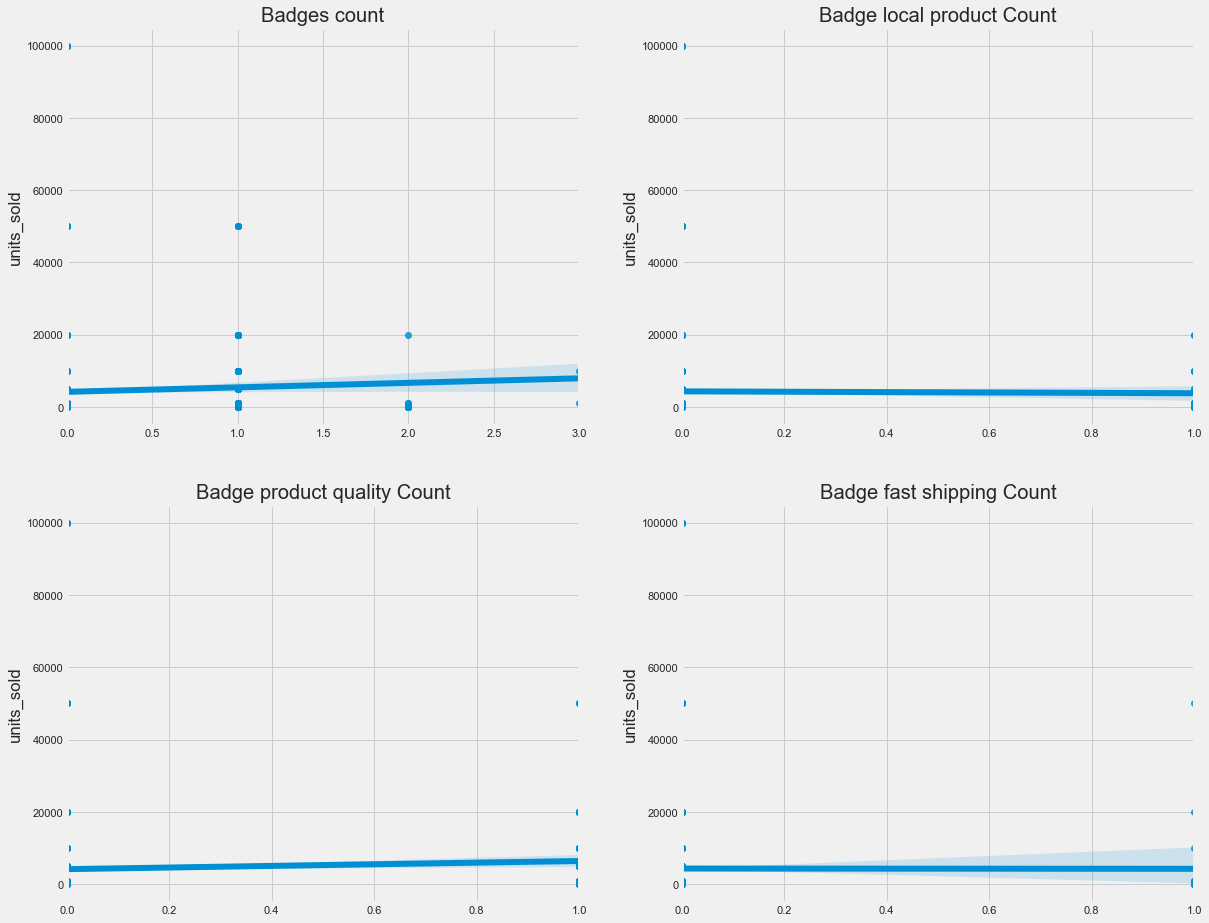

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.regplot(x="badges_count", y="units_sold", data=sales, ax=ax[0,0])
ax[0,0].set_title('Badges count')
ax[0,0].set_xlabel('')

g = sns.regplot(x="badge_local_product", y="units_sold", data=sales, ax=ax[0,1])
ax[0,1].set_title('Badge local product Count')
ax[0,1].set_xlabel('')

g = sns.regplot(x="badge_product_quality", y="units_sold", data=sales, ax=ax[1,0])
ax[1,0].set_title('Badge product quality Count')
ax[1,0].set_xlabel('')

g = sns.regplot(x="badge_fast_shipping", y="units_sold", data=sales, ax=ax[1,1])
ax[1,1].set_title('Badge fast shipping Count')
ax[1,1].set_xlabel('')


### Product Variation Inventory

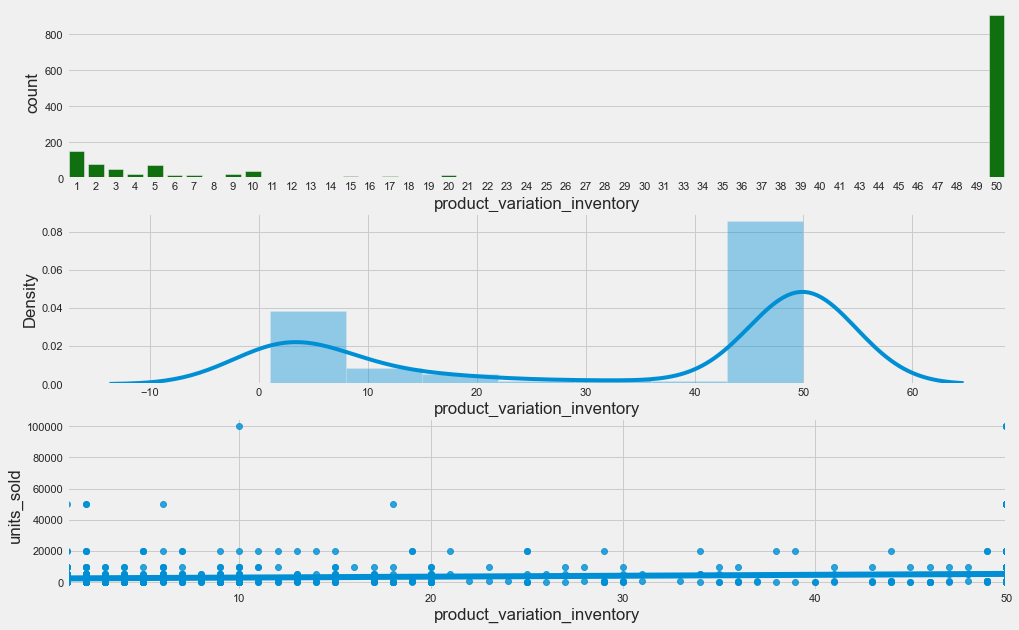

In [ ]:
fig,(ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,10))
g = sns.countplot(x="product_variation_inventory", data=sales, color='green', ax=ax1)

g = sns.distplot(sales['product_variation_inventory'], kde=True, ax=ax2)

g = sns.regplot(x="product_variation_inventory", y="units_sold", data=sales, ax=ax3)

**Mayoritas product memiliki nilai 50 pada product variation inventory**

### Shipping Option Price

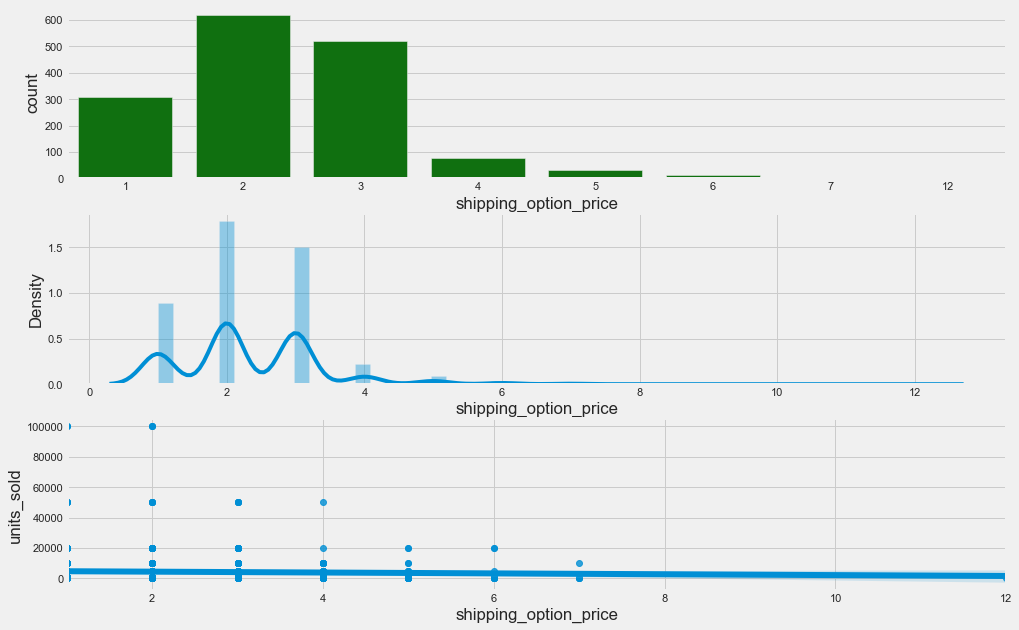

In [ ]:
fig,(ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,10))
g = sns.countplot(x="shipping_option_price", data=sales, color='green', ax=ax1)

g = sns.distplot(sales['shipping_option_price'], kde=True, ax=ax2)

g = sns.regplot(x="shipping_option_price", y="units_sold", data=sales, ax=ax3)

**mayoritas product memiliki shipping option price antara 1 sampai 3**

### Shipping Is Express

In [ ]:
sales['shipping_is_express'].value_counts()

0    1569
1       4
Name: shipping_is_express, dtype: int64

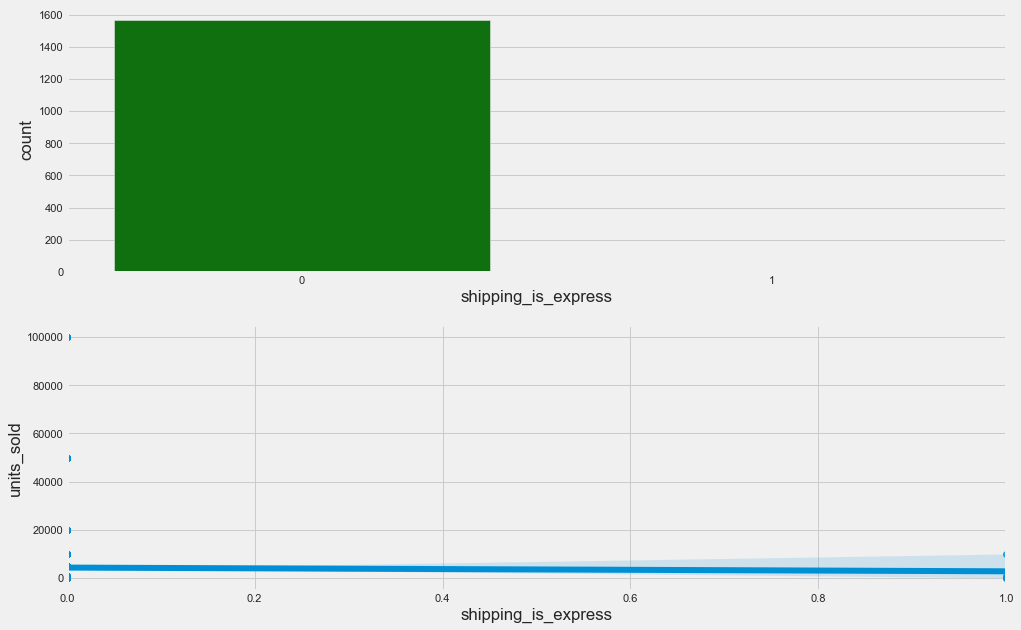

In [ ]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
g = sns.countplot(x="shipping_is_express", data=sales, color='green', ax=ax1)

g = sns.regplot(x="shipping_is_express", y="units_sold", data=sales, ax=ax2)

### Inventory Total

In [ ]:
sales['inventory_total'].value_counts()

50    1563
2        2
40       1
38       1
37       1
36       1
30       1
24       1
9        1
1        1
Name: inventory_total, dtype: int64

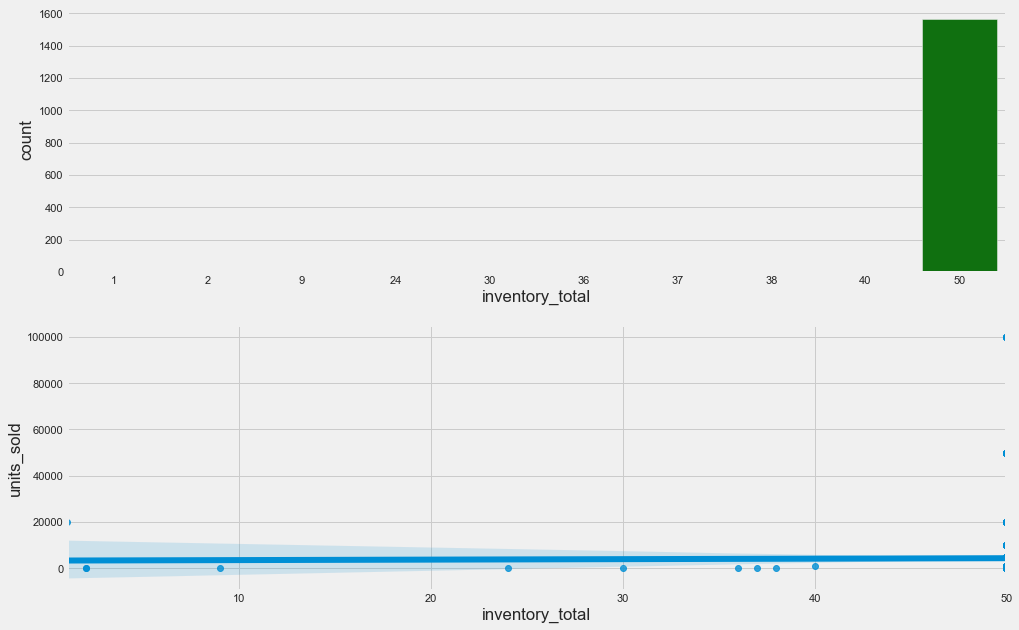

In [ ]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
g = sns.countplot(x="inventory_total", data=sales, color='green', ax=ax1)

g = sns.regplot(x="inventory_total", y="units_sold", data=sales, ax=ax2)

**nilai inventory total pada produk didominasi nilai 50**

### Has Urgency Banner

In [ ]:
sales['has_urgency_banner'].value_counts()

0.0    1100
1.0     473
Name: has_urgency_banner, dtype: int64

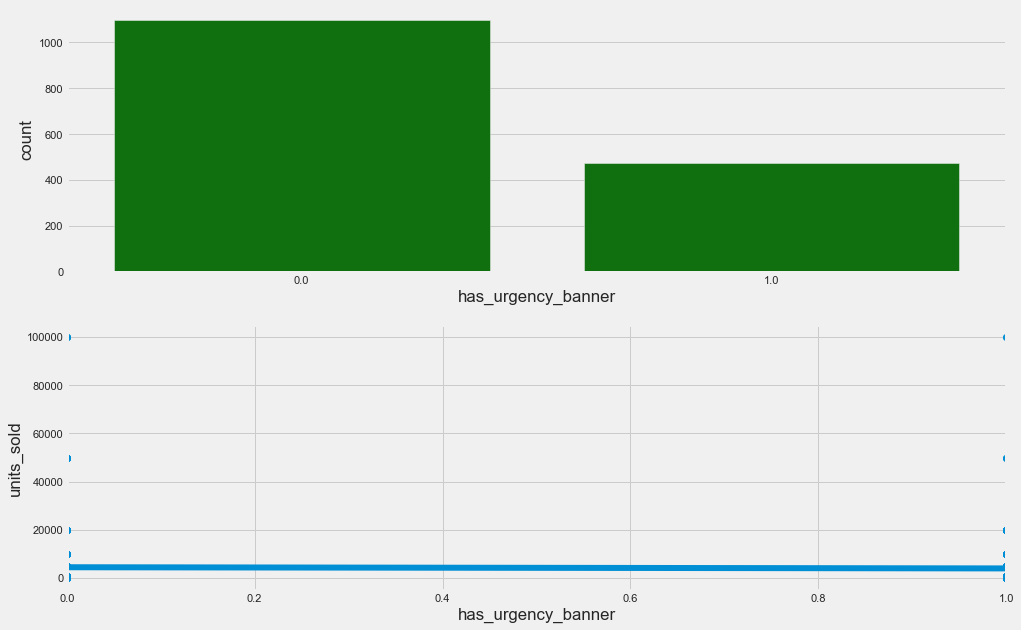

In [ ]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
g = sns.countplot(x="has_urgency_banner", data=sales, color='green', ax=ax1)

g = sns.regplot(x="has_urgency_banner", y="units_sold", data=sales, ax=ax2)

### merchant_rating_count

In [ ]:
sales['merchant_rating_count'].value_counts()

32168    15
12309    12
80093     9
42919     8
88193     8
         ..
15173     1
4924      1
21307     1
12745     1
0         1
Name: merchant_rating_count, Length: 917, dtype: int64

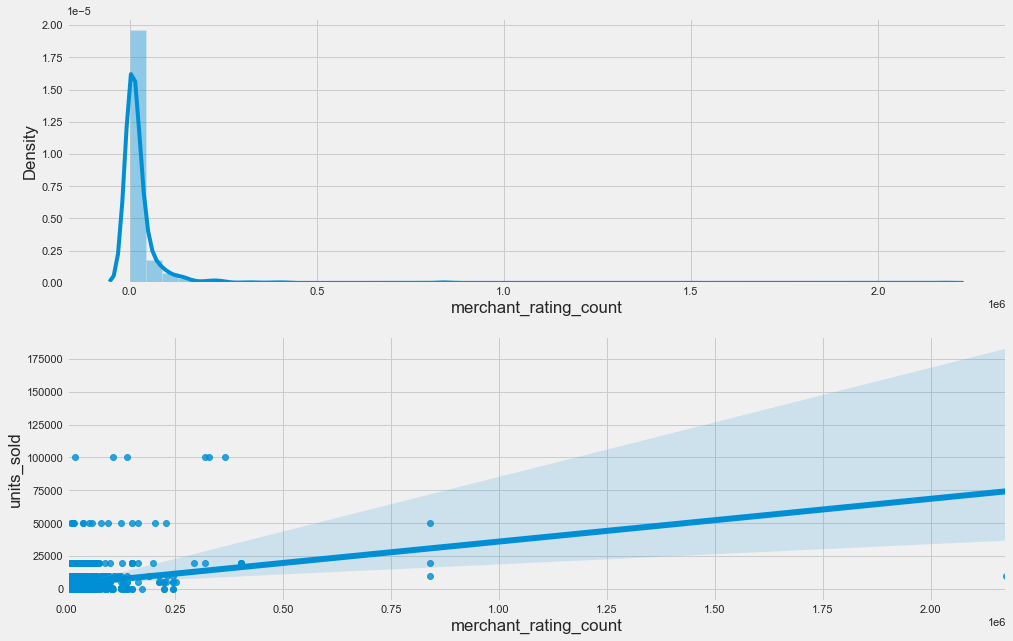

In [ ]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(15,10))

g = sns.distplot(sales['merchant_rating_count'], kde=True, ax=ax1)

g = sns.regplot(x="merchant_rating_count", y="units_sold", data=sales, ax=ax2)

In [ ]:
# _, bp = pd.DataFrame.boxplot((sales['merchant_rating_count']), return_type='both',vert=False)

# outliers = [flier.get_ydata() for flier in bp["fliers"]]
# print(len(outliers[0]))
# outliers[0].min()
# outliers

In [ ]:
sales['merchant_rating_count'].describe()

count    1.573000e+03
mean     2.649583e+04
std      7.847446e+04
min      0.000000e+00
25%      1.987000e+03
50%      7.936000e+03
75%      2.456400e+04
max      2.174765e+06
Name: merchant_rating_count, dtype: float64

In [ ]:
len(sales)

1573

In [ ]:
(173/1573)*100

10.998092816274635

### Merchant Rating

In [ ]:
sales['merchant_rating'].value_counts()

3.884544    15
4.045170    12
4.006692     9
3.867547     8
4.080891     8
            ..
4.123420     1
4.109953     1
4.188215     1
3.689320     1
3.839819     1
Name: merchant_rating, Length: 952, dtype: int64

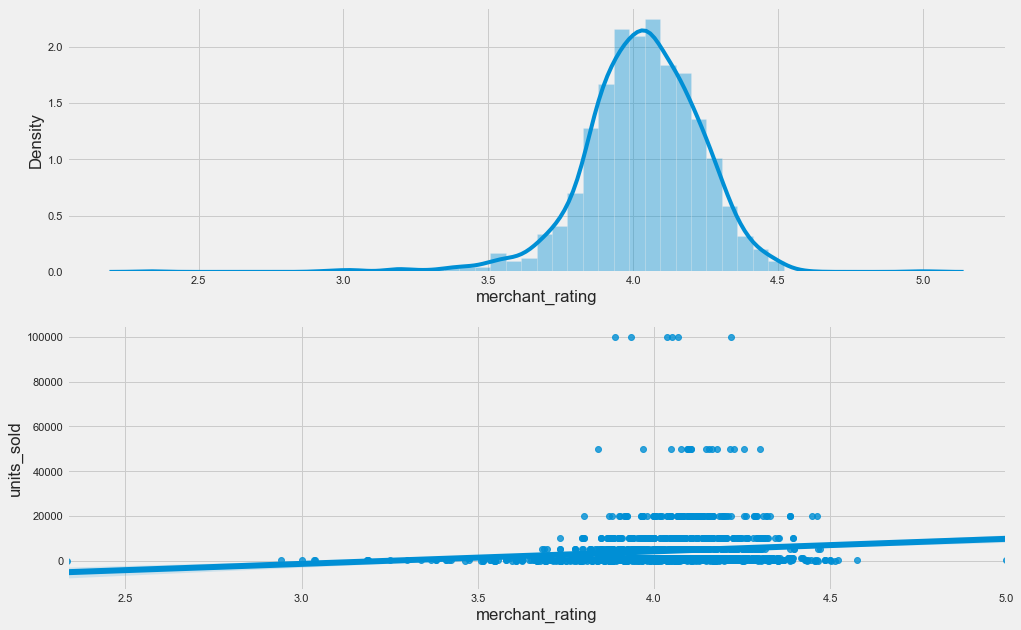

In [ ]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(15,10))

g = sns.distplot(sales['merchant_rating'], kde=True, ax=ax1)

g = sns.regplot(x="merchant_rating", y="units_sold", data=sales, ax=ax2)

In [ ]:
# _, bp = pd.DataFrame.boxplot((sales['merchant_rating']), return_type='both',vert=False)

# outliers = [flier.get_ydata() for flier in bp["fliers"]]
# print(len(outliers[0]))
# outliers[0].min()
# outliers

### Merchant Has Profile Picture

In [ ]:
sales['merchant_has_profile_picture'].value_counts()

0    1347
1     226
Name: merchant_has_profile_picture, dtype: int64

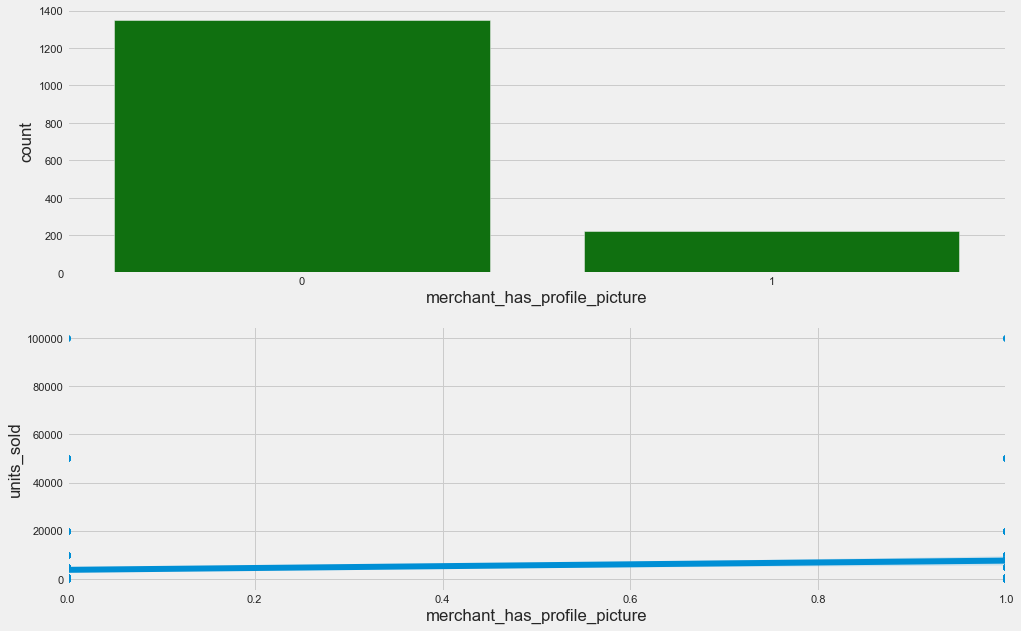

In [ ]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
g = sns.countplot(x="merchant_has_profile_picture", data=sales, color='green', ax=ax1)

g = sns.regplot(x="merchant_has_profile_picture", y="units_sold", data=sales, ax=ax2)

### Product Colour

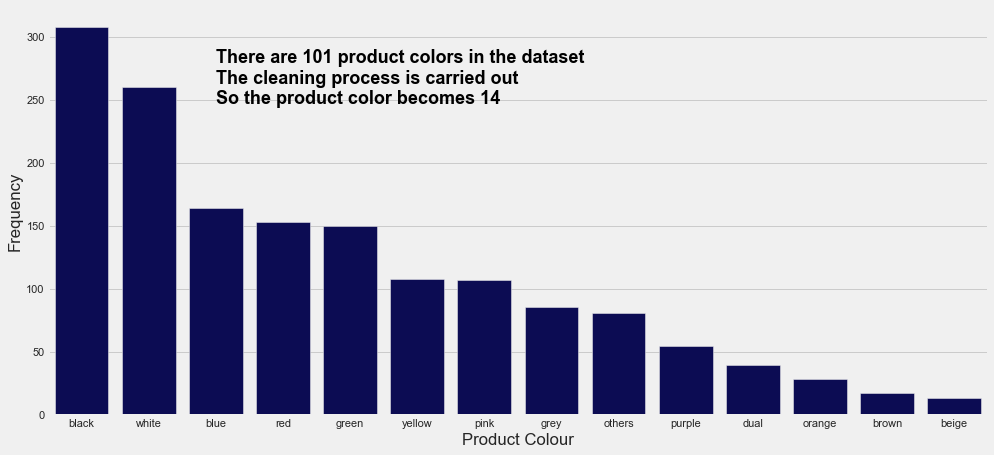

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x = 'product_color', data = temp_product_color,
              order = temp_product_color['product_color'].value_counts().iloc[:].index,
             color='#00005f')



text = '''
There are 101 product colors in the dataset
The cleaning process is carried out
So the product color becomes 14
'''
ax.text(2,230,text,horizontalalignment='left',color='black',fontsize=18,fontweight='bold')



plt.xlabel('Product Colour')
plt.ylabel('Frequency')
plt.show()

# Sampling Dataset

In [ ]:
sales = pd.concat([sales, dummies_color], axis=1)

In [ ]:
col = ['price',
 'retail_price',
 'units_sold',
 'uses_ad_boosts',
 'rating',
 'rating_count',
 'rating_five_count',
 'rating_four_count',
 'rating_three_count',
 'rating_two_count',
 'rating_one_count',
 'badges_count',
 'badge_local_product',
 'badge_product_quality',
 'badge_fast_shipping',
 'product_variation_inventory',
 'shipping_option_price',
 'shipping_is_express',
 'countries_shipped_to',
 'inventory_total',
 'has_urgency_banner',
 'merchant_rating_count',
 'merchant_rating',
 'merchant_has_profile_picture',
 'black',
 'blue',
 'brown',
 'dual',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'white',
 'yellow']

In [ ]:
sales = sales[col]

**Pada kasus ini tidak dilakukan transformasi/scaling pada data, karena berdasarkan eksperiment penggunaan nilai asli memiliki performa yang lebih baik terhadap model**<br>

**pemilihan fitur berdasarkan hasil eksperiment**

In [ ]:
# separating the independent and dependent variables

y = sales['units_sold']
X = sales.drop(labels = ['units_sold'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (1573, 35) and that of y is (1573,)


In [ ]:
# Splitting the dataset



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print('Shape of training set ', X_train.shape)
print('Shape of test set ', X_test.shape)

Shape of training set  (1258, 35)
Shape of test set  (315, 35)


# Modeling and Evaluation

In [ ]:
def rmse(targets,predictions):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val

In [ ]:
regressors = [LinearRegression(),
              Lasso(),
              Ridge(),
              ElasticNet(),
              RandomForestRegressor(random_state=1),
              xgb.XGBRegressor(random_state=42)]

df = pd.DataFrame(columns = ['Method', 'MAE', 'RMSE', 'R2 Score'])
df

,Method,MAE,RMSE,R2 Score


In [ ]:
regressors

[LinearRegression(),
 Lasso(),
 Ridge(),
 ElasticNet(),
 RandomForestRegressor(n_estimators=10, random_state=1),
 XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)]

In [ ]:
for regressor in regressors:
    print(regressor)

LinearRegression()
Lasso()
Ridge()
ElasticNet()
RandomForestRegressor(n_estimators=10, random_state=1)
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [ ]:
for regressor in regressors:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    method = str(type(regressor)).split('.')[-1][:-2]

    # MAE score
    mae = mean_absolute_error(y_test, y_pred)

    #RMSE Score
    rmse_value = rmse(y_test, y_pred)

    #R2 Score
    r2 = r2_score(y_test, y_pred)

    df = df.append({'Method': method,
                    'MAE': mae,
                    'RMSE': rmse_value,
                    'R2 Score': r2},
                     ignore_index=True)

In [ ]:
df

,Method,MAE,RMSE,R2 Score
0,LinearRegression,1745.678936,3294.919673,0.789857
1,Lasso,1742.303167,3290.734243,0.790391
2,Ridge,1745.685969,3289.384669,0.790563
3,ElasticNet,1631.238505,3228.432121,0.798253
4,RandomForestRegressor,1311.610159,3114.446328,0.812247
5,XGBRegressor,1404.048024,4757.174766,0.561951


# Tuning Hyperparameters

In [ ]:
param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10],
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

rf = RandomForestRegressor()

grid_search_forest = GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train, y_train)

In [ ]:
grid_search_forest.best_estimator_


In [ ]:
rf = RandomForestRegressor(n_estimators=25,max_features=5)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

method = str(type(regressor)).split('.')[-1][:-2]

# MAE score
mae = mean_absolute_error(y_test, y_pred)
print('MAE : ',mae)

#RMSE Score
rmse_value = rmse(y_test, y_pred)
print('RMSE : ',rmse_value)

#R2 Score
r2 = r2_score(y_test, y_pred)
print('R2 Score : ',r2)


MAE :  1168.5870476190476
RMSE :  2895.526254316728
R2 Score :  0.8377146562416321


# Feature importance

<AxesSubplot:xlabel='importance', ylabel='index'>

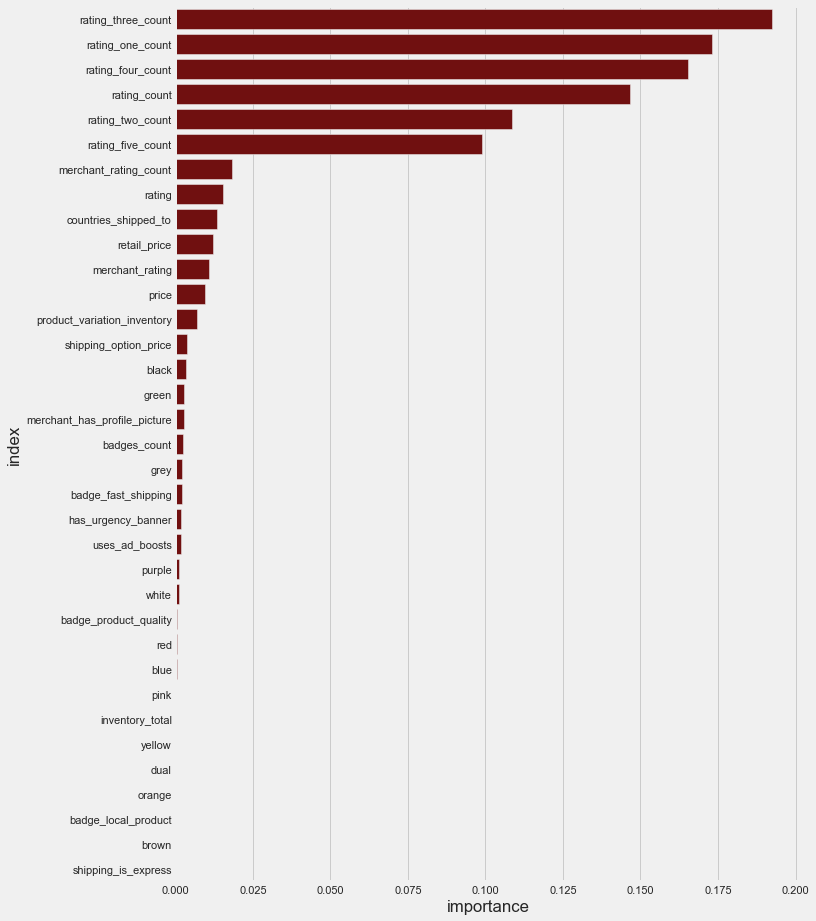

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

fig, ax = plt.subplots(1,1, figsize=(10,15))
sns.barplot(x='importance', y='index', color='#800000',data=feature_importances.reset_index())

# Insight

**Performa Random Forest**<br>
*  Terdapat banyak data anomali atau outlier<br><br>

* Data tidak dinormalisasi, berdasarkan hasil percobaan data yang tidak dinormalisasi lebih baik dan cocok untuk random forest. random forest merupakan tree base sehingga metode ini cukup baik untuk menangani outlier.<br><br>

* Terdapat multicolinearity, dimana random forest tidak terlalu signifikan pengaruh terhadap adanya multicolinearity.<br><br>

* walaupun xgboost lebih "canggih" dibandingkan random forest, tetapi ketika data sedikit algoritma simple akan lebih baik

**Insights**<br>
*  Rating (rating, rating_count, rating_one_count, rating_two_count, rating_three_count, rating_four_count, rating_five_count, merchant_rating_count) memiliki korelasi yang kuat terhadap penjualan suatu produk. dapat diasumsikan bahwa potensi terjualnya produk tergantung pada rating yang dimiliki<br><br>

* Merchant rating antara  3.5 - 4.5 memiliki performa yang baik terhadap unit penjualan<br><br>

* Pembeli lebih tertarik terhadap produk yang tidak memiliki urgency banner<br><br>

* Top 2 product color adalah black dan white<br><br>

* discount memiliki korelasi postif terhadap unit penjualan. Secara umum, semakin banyak diskon semakin meningkat penjualan, semakin banyak uang yang dibakar.<br><br>

* dll